# Imports

In [1]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Basic Info

In [2]:
#---------------- Adjust Parameters Here -----------------# 
subject = "ACR_20"
exp = 'swisin'
stores = ['NNXo', 'NNXr']
rel_state='NREM'
#---------------------------------------------------------#


# ----------------------------------------- subject_info + Hypno -----------------------------------------
h = acr.io.load_hypno_full_exp(subject, exp)
si = acr.info_pipeline.load_subject_info(subject)
sort_ids = [f'{exp}-{store}' for store in stores]
recordings = acr.info_pipeline.get_exp_recs(subject, exp)
#---------------------------------------------------------------------------------------------------------


# ----------------------------------------- Load Basic Info -----------------------------------------
stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
reb_start = h.hts(stim_end-pd.Timedelta('15min'), stim_end+pd.Timedelta('1h')).st('NREM').iloc[0].start_time
if reb_start < stim_end:
    stim_end_hypno = h.loc[(h.start_time<stim_end)&(h.end_time>stim_end)] # if stim time is in the middle of a nrem bout, then it can be the start of the rebound
    if stim_end_hypno.state.values[0] == 'NREM':
        reb_start = stim_end
    else:
        raise ValueError('Rebound start time is before stim end time, need to inspect')

assert reb_start >= stim_end, 'Rebound start time is before stim end time'

bl_start_actual = si["rec_times"][f'{exp}-bl']["start"]
bl_day = bl_start_actual.split("T")[0]
bl_start = pd.Timestamp(bl_day + "T09:00:00")

if f'{exp}-sd' in si['rec_times'].keys():
    sd_rec = f'{exp}-sd'
    sd_end = pd.Timestamp(si['rec_times'][sd_rec]['end'])
else:
    sd_rec = exp
    sd_end = stim_start
sd_start_actual = pd.Timestamp(si['rec_times'][sd_rec]['start'])
sd_day = si['rec_times'][sd_rec]['start'].split("T")[0]
sd_start = pd.Timestamp(sd_day + "T09:00:00")

# Load Data

In [3]:
# BANDPOWER DATA
#-------------------------------
bp = acr.io.load_concat_bandpower(subject, recordings, stores, hypno=True);
bp_rel = kde.xr.utils.rel_by_store(bp, state=rel_state, t1=None, t2=None);

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda

In [4]:
# UNIT DATA
#-------------------------------
df, idf = acr.pl_units.load_spikes_polars(subject, sort_ids, info=True, exclude_bad_units=True)

In [5]:
fp = acr.io.load_concat_raw_data(subject, recordings, stores)
nnxo = fp.prb('NNXo').ts(stim_start, reb_start+pd.Timedelta('1h'))
nnxr = fp.prb('NNXr').ts(stim_start, reb_start+pd.Timedelta('1h'))

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda

In [7]:
pon, poff = acr.stim.get_individual_pulse_times(subject, exp, 'Wavt')

# OFF Induction

In [8]:
time_of_interest = 18435
start = pd.Timestamp(si['rec_times'][exp]['start'])
stim_t1 = start+pd.Timedelta(f'{time_of_interest}s')
stim_t2 = stim_t1+pd.Timedelta('5s')

In [38]:
#stim_t1= pd.Timestamp('2023-01-03 13:47:47')
stim_t1= pd.Timestamp('2023-01-03 13:51:55')
stim_t2 = stim_t1+pd.Timedelta('5s')
#data = nnxo.ts(t1, t2).sel(channel=chans).data

## NNXo

In [21]:
chans = [2, 4, 6, 7, 8, 11, 12, 13, 14, 16]
plot_df = df.ts(stim_t1, stim_t2).prb('NNXo')
plot_df = plot_df.with_columns(unit_vals = pl.col('channel'))

# Assuming you have a Polars DataFrame named 'df'
num_rows_to_remove = 250  # Specify the number of rows to remove

# Calculate the fraction of rows to keep
frac_to_keep = 1 - (num_rows_to_remove / len(plot_df))

# Remove the specified number of rows randomly
plot_df = plot_df.sample(fraction=frac_to_keep, seed=None)

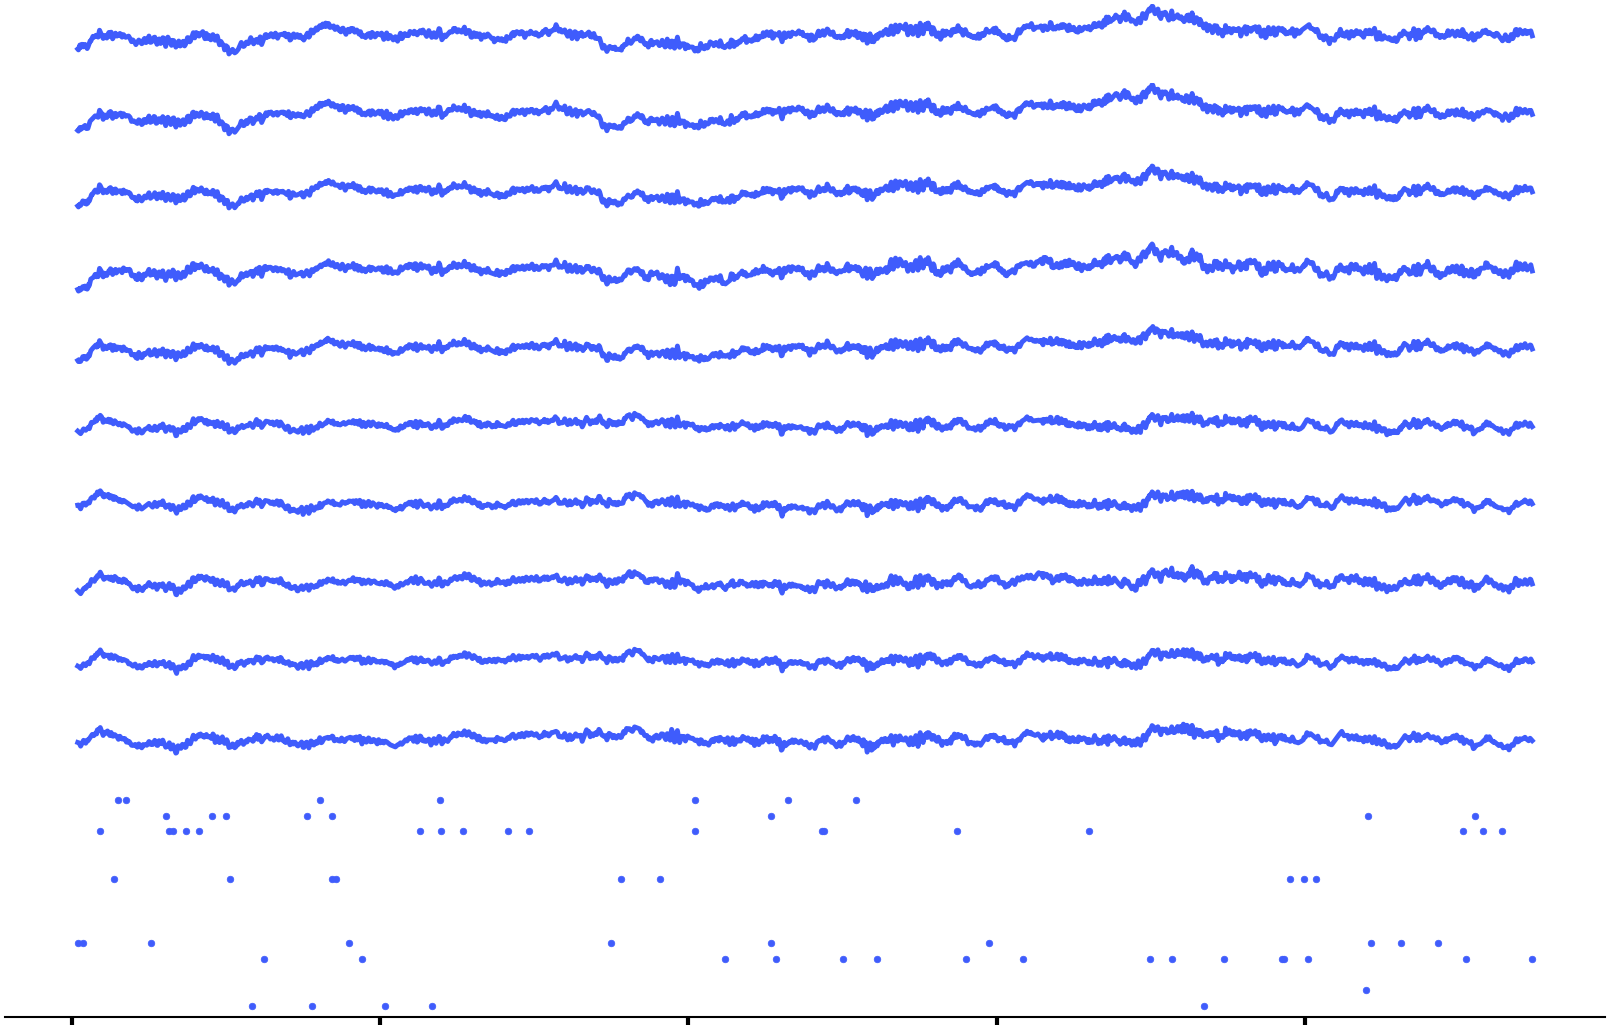

In [23]:

# -------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_continuous.mplstyle')
f, ax = plt.subplots(11, 1, height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4], figsize=(40, 25))
for i, chan in enumerate(chans):
    ax[i].plot(nnxo.ts(stim_t1, stim_t2).ch(chan).datetime.values, nnxo.ts(stim_t1, stim_t2).ch(chan).values, color='#3F5CFC', linewidth=7)
    #ax[i].set_ylabel(f'Ch {chan}')
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_ylim(-900, 900)
ax[10].scatter(plot_df['datetime'], plot_df['unit_vals'], s=90, color='#3F5CFC')
ax[len(chans)].set_yticks([])
ax[len(chans)].set_xticklabels([])
ax[len(chans)].spines['top'].set_visible(False)
ax[len(chans)].spines['right'].set_visible(False)
ax[len(chans)].spines['left'].set_visible(False)
f.savefig(f'./plots/{subject}--{exp}--optrode_tonic_reduction.png', dpi=300, bbox_inches='tight')

## NNXr

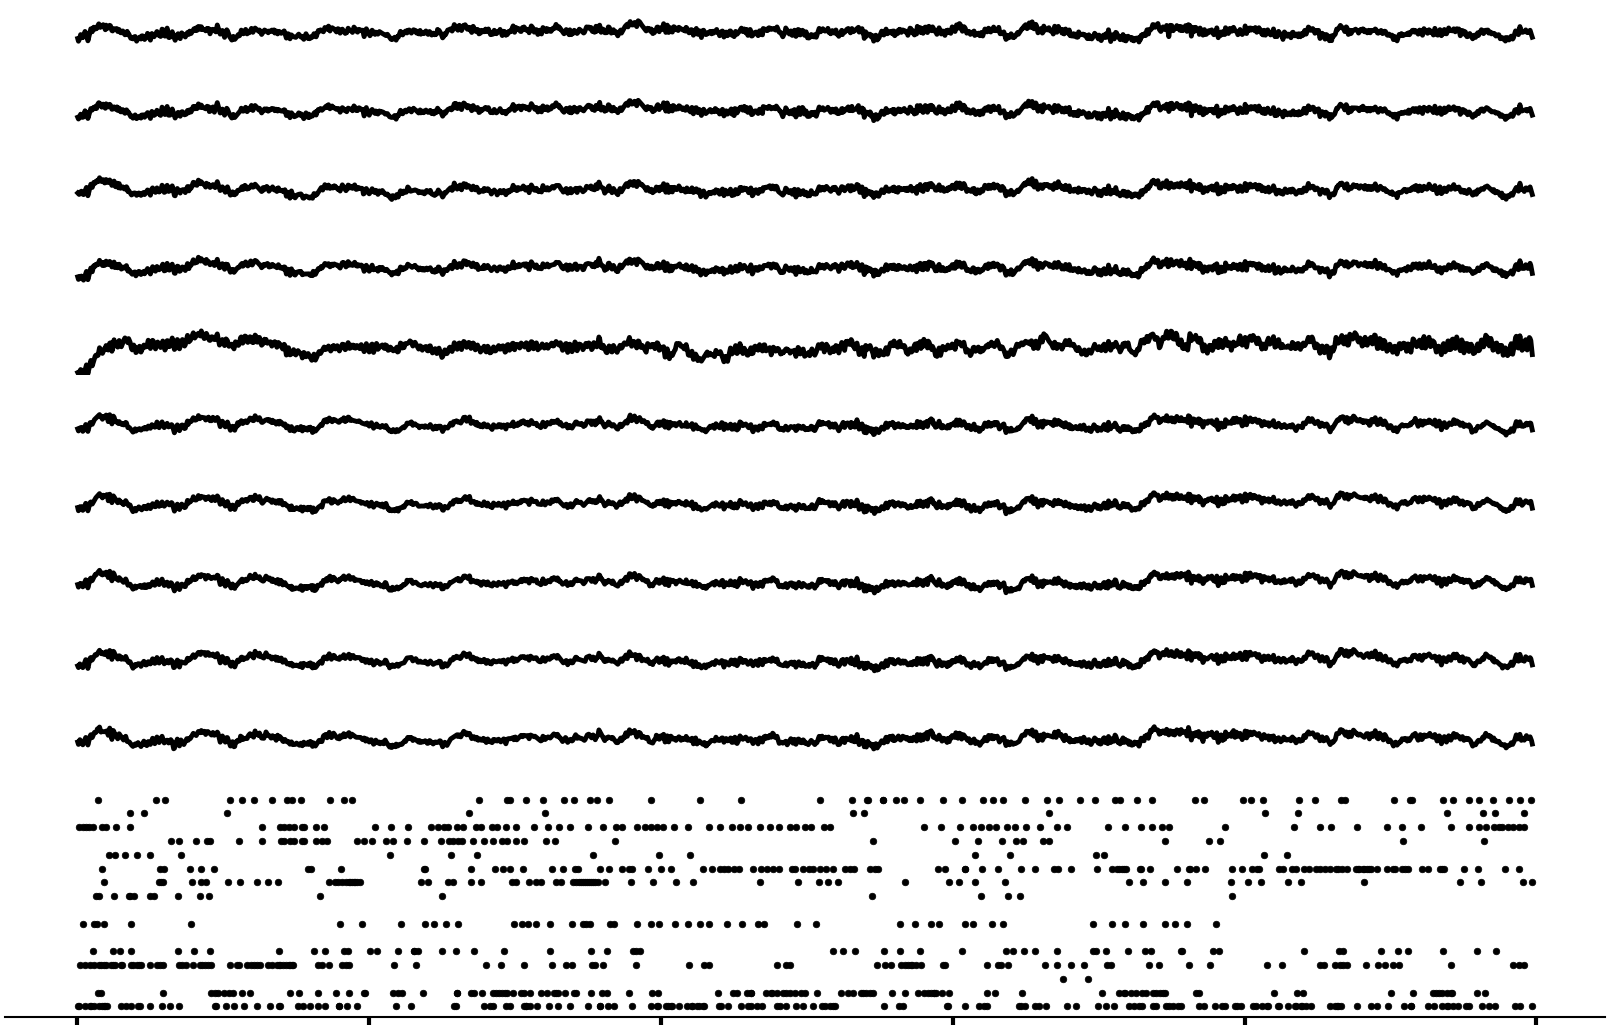

In [24]:
chans = [1, 2, 5, 6, 8, 11, 12, 13, 14, 15]
plot_df = df.ts(stim_t1, stim_t2).prb('NNXr')
plot_df = plot_df.with_columns(unit_vals = pl.col('channel'))

# -------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_continuous.mplstyle')
f, ax = plt.subplots(11, 1, height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4], figsize=(40, 25))
for i, chan in enumerate(chans):
    ax[i].plot(nnxr.ts(stim_t1, stim_t2).ch(chan).datetime.values, nnxr.ts(stim_t1, stim_t2).ch(chan).values, color='black', linewidth=7)
    #ax[i].set_ylabel(f'Ch {chan}')
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_ylim(-950, 950)
ax[10].scatter(plot_df['datetime'], plot_df['unit_vals'], s=90, color='black')
ax[len(chans)].set_yticks([])
ax[len(chans)].set_xticklabels([])
ax[len(chans)].spines['top'].set_visible(False)
ax[len(chans)].spines['right'].set_visible(False)
ax[len(chans)].spines['left'].set_visible(False)
f.savefig(f'./plots/{subject}--{exp}--NNXr_tonic_reduction.png', dpi=300, bbox_inches='tight')